<a href="https://colab.research.google.com/github/weprintmoney/LLMPractice/blob/main/GA_NLP_LVC_10_Fine_tuning_Llama_2_with_QLoRA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><p float="center">
  <img src="https://upload.wikimedia.org/wikipedia/commons/e/e9/4_RGB_McCombs_School_Brand_Branded.png" width="300" height="100"/>
  <img src="https://mma.prnewswire.com/media/1458111/Great_Learning_Logo.jpg?p=facebook" width="200" height="100"/>
</p></center>

<h1><center><font size=8>Fine-tuning Llama2 on a Custom Dataset</center></font></h1>
<h1><center>using QLoRA</center></h1>
<h3><center>Charlcye Mitchell, May 2024</center></h3>

## **Learning Notebook Objectives**

In this learning notebook, we shall go over the code workflow to understand how we can fine-tune the Llama 2 open-source LLM on a custom dataset of prompt-response pairs. Fine-tuning is, of course, a critical aspect of customizing Large Language Models beyond their generic training regimen, to specific use cases involving organizational data and business applications. It is hence a very important part of working hands-on with LLMs and using them to create curated solutions for your organizational needs.

## **Why should we Fine-tune LLMs?**

LLMs are trained to understand instructions on specific tasks, and Prompt Engineering by itself is of course a powerful way of unlocking these capabilities of a LLM without needing to tweak the LLM's internal weights, which is obviously more compute-expensive.

However, there are two important scenarios where fine-tuning LLMs is helpful.

- **Instructions for a specific task or domain were not adequately ingested by the model during the training phase** (for e.g., the model might not have seen a lot of financial data during training)
- **The model struggles to understand specific instructions** on the format or quality of response expected (for e.g., the model does not present output in a specific tone expected from a business).

**To fine-tune, we start with the base model (i.e., Llama2) and attach a small proportion of learnable weights (i.e., an adapter) to the layers of the model. The final model is a layerwise combination of the base model and the corresponding adapter.**

Note that Fine-tuning should only be considered if the behavior of the model cannot already be controlled through careful Prompt Engineering and Retrieval-Augmented Generation, which are always the first two ports of call in trying to customize an LLM with respect to your custom application.

## **The Llama 2 Model**

At the heart of Llama2 is the Transformer architecture. While a deep understanding of Transformer models is not critical to devise effective prompts, an understanding of these models becomes critical when the objective is to fine-tune.

A deep-dive into Transformer models and the GPT architecture is presented [here](https://github.com/pgurazada/gpt-brick-by-brick) (this is optional but recommended reading, to understand the individual blocks of Llama2).

[Llama 2 is a GPT-style model](https://arxiv.org/pdf/2307.09288.pdf) that has been trained on a large corpus of text data using the overall approach presented in the figure below.

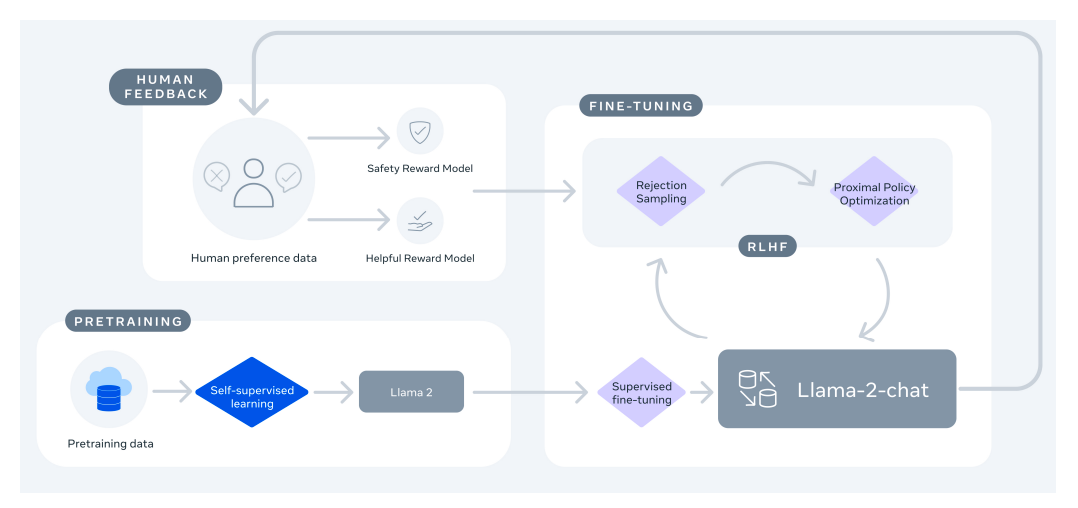

There are two variants of Llama 2: the base model that is trained on next-token prediction, and the chat model that is trained to be aligned with human feedback. For each of these variants there are 3 further variants in terms of model sizes - 7 billion parameters, 13 billion parameters, 70 billion parameters.

In this notebook, **we will fine-tune the 7-billion parameter variant of LLama 2** (architecture presented below) using a Parameter-efficient training method, owing to the memory & RAM constraints of the free tier of Google Colab.

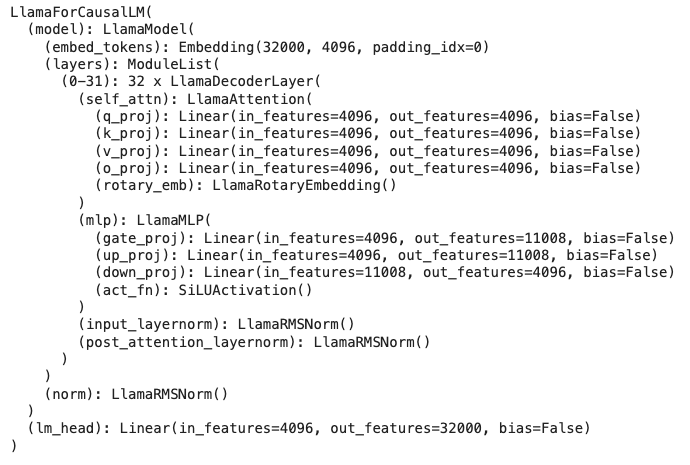

Here is a summary of the Llama 2 architecture:
- the vocabulary size of the model is 32000 tokens
- Each input batch is embedded in the first layer to 4096 dimensions
- The embedding layer is then fed into a set of 32 decoder layers each of which has a dimension of 4096
- Positional embedding is handled using Rotary Embeddings
- Each decoder layer is then sent to a set of fully connected layers that project these 4096 dimensions to 11008 dimensions and then back to 4096 dimensions
- The final unembedding layer projects the contextualized 4096-dimensional output from the transformer blocks to the vocabulary space   

## **LoRA and QLoRA**

**Fine-tuning all the 7 billion parameters of Llama 2 (i.e., full fine-tuning)** to adapt to a specific task is not only **prohibitively expensive computationally**, but also runs the risk of the model losing the knowledge ingested during the training phase.

**Instead, we use a different approach - Low Rank Adaptation (LoRA)** - that reduces the number of parameter updates that need to be done while retaining the knowledge ingested during pretraining. LoRA is one among a family of models that are referred to as Parameter-Efficient Fine Tuning (PEFT) models. [The LoRA approach](https://arxiv.org/abs/2106.09685) is presented in the figure below.

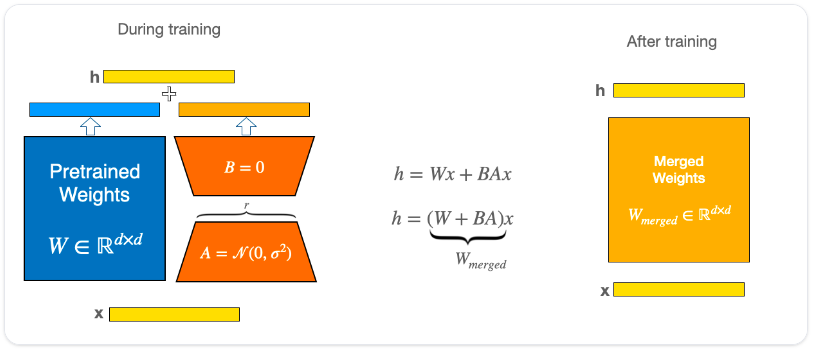

[Source](https://huggingface.co/docs/peft/conceptual_guides/lora)

As depicted in the above figure, the original weights of the transformer blocks $W$ remain frozen during fine-tuning with LoRA. Training is confined to two low-rank ($r$) matrices $A$ and $B$ and the learned deposition of $W = BA$ is then added back to the pretrained weights. In this way, LoRA acts as a source of adapter matrices that can be trained with a much smaller computational footprint. For example, while the original model has a dimensionality of $d_{\text{model}}=4096$ (across all the 32 layers), we typically use a LoRA adaptor with $r = 8$ or $r = 16$. This dramatically reduces the parameters that need to be estimated. For example, for $r = 8$, $A \in \mathbb{R}^{4096 \times 8}$ and $A \in \mathbb{R}^{8 \times 4096}$.


In [ ]:
print((4096*4096),(4096*8 + 8*4096))

16777216 65536


In [ ]:
(4096*8 + 8*4096)/((4096*4096))

0.00390625

There are two main parameters to tune in the LoRA approach.
- rank ($r$): usually a choice between 4, 8, or 16
- [scaling coefficient ($\alpha$)](https://civitai.com/articles/2125/what-lora-alpha-actually-does-in-theory): usually fixed at 16

$r$ defines the dimensions of the low-rank matrices, while $\alpha$ determines the scaling factor for the weight matrices. It is common to [freeze $\alpha = 16$](https://arxiv.org/pdf/2308.07317v1.pdf), while varying the values of $r = \alpha, \alpha/2, \alpha/4$ and arriving at the optimal value of $r$ that gives the lowest validation loss (note that we use the same loss used for the base model, e.g., perplexity or log loss).

[QLoRA](https://arxiv.org/pdf/2305.14314.pdf) improves the efficiency of LoRA training further by optimizing few key parameters of the LoRA adapter (see figure below). Key optimizations executed by QLoRA are:

- 4-bit NormalFloat quantization that shifts the base Llama2 model from 16-bit to 4-bit
- paged optimizers that shift weights to CPU if the GPU RAM is full (instead of throwing up an error)


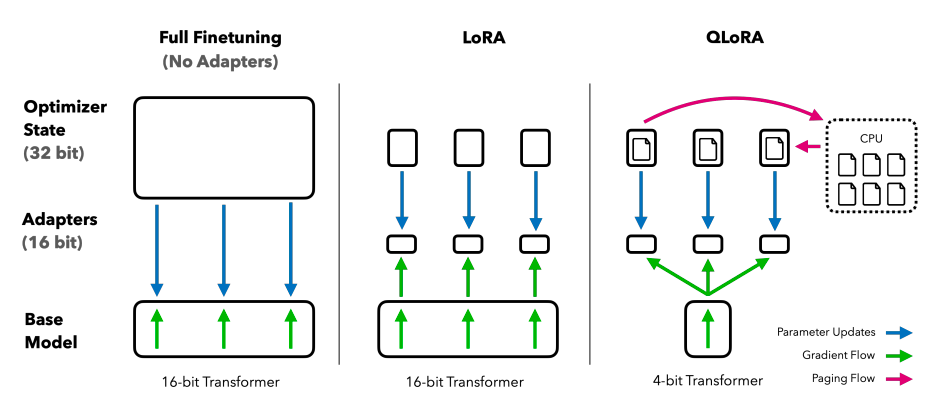

Let us now implement the fine-tuning procedure described in this section for the Llama 2 7-billion parameter chat model using QLoRA.

## **Setup**

**Note:** This notebook needs to be executed with a GPU runtime. All the steps presented in this notebook (i.e., loading pretraining models and fine-tuning) depend on the acceleration provided by a GPU.

We will also save the LoRA adapter models estimated in this notebook to Google Drive.

## **Installation**

In [ ]:
!pip install -q accelerate==0.21.0 \
                peft==0.4.0 \
                bitsandbytes==0.40.2 \
                transformers==4.31.0 \
                trl==0.4.7 \
                datasets==2.13.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 73.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.6/485.6 kB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 41.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 16.3 MB/s eta 0:00:00


The functionalities we use of these packages are:
- `transformers`, `datasets`: helpers to load models and datsets from the HuggingFace ecosystem
- `peft`: contains implementation of LoRA
- `bitsandbytes`: facilitates application of QLoRA in conjunction with `peft`
- `trl`: abstractions to train the LoRA adapters

## **Importing the Libraries Required**

In [ ]:
import os
import torch
import locale

from datasets import load_dataset

from transformers import (
    LlamaForCausalLM,
    LlamaTokenizerFast,
    BitsAndBytesConfig,
    TrainingArguments
)

from peft import LoraConfig, PeftModel
from trl import SFTTrainer

The following code allows us to run shell commands on Colab (we need shell commands to check file sizes of the estimated models).

In [ ]:
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"

locale.getpreferredencoding = getpreferredencoding

## **Preparing the training data**

The first step in fine-tuning is to prepare the dataset in accordance with the prompt template of Llama 2.

In this example, we reformat a [conversation-summary dataset](https://huggingface.co/datasets/knkarthick/dialogsum) to adapt it to the Llama 2 prompt pattern.

In [ ]:
dataset = load_dataset("knkarthick/dialogsum")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/knkarthick___csv/knkarthick--dialogsum-d7c54319f1f4a15f/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

For fine-tuning, we select a random sample of 100 training examples and 50 validation examples from this dataset.

In [ ]:
train_size, validation_size = 100, 50
training_dataset = dataset['train'].shuffle(seed=42).select(range(train_size))
validation_dataset = dataset['validation'].shuffle(seed=42).select(range(validation_size))

The prompt format for Llama 2 is presented below:

In [ ]:
llama2_template = """<s>[INST]<<SYS>>
{system_message}
<</SYS>>

{user_message} [/INST]
{assistant_message}</s>"""

We now create a formatting function that takes in an example from the random sample, and formats the example to be a `training_input` in the template format of Llama 2.

In [ ]:
def format_input(example, prompt_template):
    system_message = "Summarize the following conversation."
    example_dialogue = example['dialogue']
    example_summary = example['summary']

    formatted_prompt = prompt_template.format(
        system_message=system_message,
        user_message=example_dialogue,
        assistant_message=example_summary
    )

    return {'formatted_prompt': formatted_prompt}

This function can now be applied to all the instances in the training dataset and the validation dataset.

In [ ]:
formatted_training_dataset = training_dataset.map(
    format_input,
    fn_kwargs={'prompt_template': llama2_template}
)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [ ]:
formatted_training_dataset[0]

{'id': 'train_6155',
 'dialogue': "#Person1#: Hello, Anna speaking!\n#Person2#: Hey, Anna, this is Jason.\n#Person1#: Jason, where have you been hiding lately? You know it's been a long time since your last call. Have you been good?\n#Person2#: Yes. How are you, Anna?\n#Person1#: I am fine. What have you been doing?\n#Person2#: Working. I've been really busy these days. I got a promotion.\n#Person1#: That's great, congratulations!\n#Person2#: Thanks. I am feeling pretty good about myself too. You know, bigger office, a raise and even an assistant.\n#Person1#: That's good. So I guess I'll have to make an appointment to see you.\n#Person2#: You are kidding.\n#Person1#: How long have you been working there?\n#Person2#: A bit over two years. This is a fast-moving company, and seniority isn't the only factor in deciding promotions.\n#Person1#: How do you like your new boss?\n#Person2#: She is very nice and open-minded.\n#Person1#: Much better than the last one, huh?\n#Person2#: Yeah. He was

In [ ]:
formatted_validation_dataset = validation_dataset.map(
    format_input,
    fn_kwargs={'prompt_template': llama2_template}
)

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

In [ ]:
formatted_validation_dataset[0]

{'id': 'dev_473',
 'dialogue': "#Person1#: Did you enjoy your weekend at the highland hotel? I heard it's and excellent place to stay and has good facilities.\n#Person2#: I had a wonderful time. The rooms are not very big, but they are well furnished. The restaurant is excellent and reasonably priced. There's a sauna and a Jacuzzi.\n#Person1#: Do they have a swimming pool?\n#Person2#: No, they don't. they have a beauty parlor, but I didn't go there.\n#Person1#: What's the service like?\n#Person2#: It's very good. Check in and check out at the reception only took a few minutes. The wait staff is very good. A waiter recommended their baked fish, which tasted wonderful. The hotel was quite full, so I'd suggest making a reservation if you intend to go there. The hotel offers a discount at the weekends.\n#Person1#: It sounds perfect. Did you have any complaints at all?\n#Person2#: There was a problem with the internet access, so I couldn't check my email, but I didn't complain about it to t

We will use this validation set to estimate the loss during training.

## **Loading the Base Llama 2 Chat Model**

We begin the fine-tuning by downloading as our base the Llama 2 chat model. However, we will need to load it in 4-bit precision as prescribed by QLoRA. This is achieved by tweaking the parameters offered by `BitsAndBytesConfig`.


In [ ]:
base_model_name = "NousResearch/Llama-2-7b-chat-hf"

In [ ]:
# Load tokenizer and model with QLoRA configuration
# Compute dtype for 4-bit base models
compute_dtype = getattr(torch, "float16")

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=False
)

In [ ]:
# Load the entire model on the GPU 0
device_map = {"": 0}

We can now load the pre-trained Llama 2 model in this configuration like so:

In [ ]:
model = LlamaForCausalLM.from_pretrained(
    base_model_name,
    quantization_config=bnb_config,
    device_map=device_map
)

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/179 [00:00<?, ?B/s]

In [ ]:
model.config.use_cache = False
model.config.pretraining_tp = 1

We also load the tokenizer specific to Llama 2 like so:

In [ ]:
tokenizer = LlamaTokenizerFast.from_pretrained(base_model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right" # Fix weird overflow issue with fp16 training

tokenizer_config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

## **Defining the LoRA Parameters**

We begin by $\alpha = 16$, and a starting value of $r = 4$. If the observed loss is sub-optimal then we can increase the value of $r$ to 8 and 16. It is not a good practise to increase the value of $r > \alpha$.

In [ ]:
lora_r = 4

lora_alpha = 16

# Dropout probability for LoRA layers
lora_dropout = 0.1

In [ ]:
# Load LoRA configuration
lora_config = LoraConfig(
    r=lora_r,
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    bias="none",
    target_modules = ['q_proj','k_proj','v_proj','o_proj','gate_proj','down_proj','up_proj','lm_head'],
    task_type="CAUSAL_LM"
)

Note that we want to attach LoRA adapters to all the components of the transformer block (this is shown to yield the best results).

## **Model Training**

Beyond the LoRA parameters, we also need to select optimal training arguments that enable efficient training and logging (these arguments can be left untouched, unless results are suboptimal).

Note that we are training here for 3 epochs (more epochs are better but need more GPU-time).

In [ ]:
training_arguments = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    evaluation_strategy="epoch",
    gradient_accumulation_steps=1,
    optim="paged_adamw_32bit",
    save_steps=0,
    logging_steps=50,
    learning_rate=2e-4,
    weight_decay=.001,
    fp16=False,
    bf16=False,
    max_grad_norm=0.3, # Maximum gradient normal (gradient clipping)
    max_steps=-1,
    warmup_ratio=.03,
    group_by_length=True, # Group sequences into batches with same length
    lr_scheduler_type="cosine"
)

Finally, we define an instance of the `SFTTrainer` using the base model and the PEFT configuration defined above (using `LoRAConfig`). The trainer uses these components to assemble the adapter and the training arguments to estimate the weights of the adapter. To estimate loss, we also pass in the training and validation datasets, along with the tokenizer.

In [ ]:
trainer = SFTTrainer(
    model,
    train_dataset=formatted_training_dataset,
    eval_dataset=formatted_validation_dataset,
    peft_config=lora_config,
    dataset_text_field="formatted_prompt",
    max_seq_length=4096,
    tokenizer=tokenizer,
    args=training_arguments,
    packing=False # Pack multiple short examples in the same input sequence to increase efficiency
)

/usr/local/lib/python3.10/dist-packages/peft/utils/other.py:102: FutureWarning: prepare_model_for_int8_training is deprecated and will be removed in a future version. Use prepare_model_for_kbit_training instead.
  warnings.warn(


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

We can now start the training process and inspect the validation losses.

In [ ]:
trainer.train()

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,1.357420
2,1.478300,1.324114
3,1.478300,1.325219


TrainOutput(global_step=75, training_loss=1.3763099161783854, metrics={'train_runtime': 554.7584, 'train_samples_per_second': 0.541, 'train_steps_per_second': 0.135, 'total_flos': 2283825245405184.0, 'train_loss': 1.3763099161783854, 'epoch': 3.0})

We repeat this training process with different values of $r$ and choose $r$ with the lowest validation loss.

## **Model Inference**

Once we arrive at the optimal value of $r$, we can use the best model to check the performance of the model during inference.

In [ ]:
test_dataset = dataset['test']

In [ ]:
test_dataset[0]

{'id': 'test_0_1',
 'dialogue': "#Person1#: Ms. Dawson, I need you to take a dictation for me.\n#Person2#: Yes, sir...\n#Person1#: This should go out as an intra-office memorandum to all employees by this afternoon. Are you ready?\n#Person2#: Yes, sir. Go ahead.\n#Person1#: Attention all staff... Effective immediately, all office communications are restricted to email correspondence and official memos. The use of Instant Message programs by employees during working hours is strictly prohibited.\n#Person2#: Sir, does this apply to intra-office communications only? Or will it also restrict external communications?\n#Person1#: It should apply to all communications, not only in this office between employees, but also any outside communications.\n#Person2#: But sir, many employees use Instant Messaging to communicate with their clients.\n#Person1#: They will just have to change their communication methods. I don't want any - one using Instant Messaging in this office. It wastes too much tim

In [ ]:
system_message = "Summarize the following conversation."
test_dialogue = test_dataset[0]['dialogue']
test_summary = test_dataset[0]['summary']

In [ ]:
prompt_template = """<s>[INST]<<SYS>>
{system_message}
<</SYS>>

{user_message} [/INST]"""

In [ ]:
prompt = prompt_template.format(
    system_message=system_message,
    user_message=test_dialogue
)

In [ ]:
input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to('cuda')

In [ ]:
generation_output = trainer.model.generate(
      input_ids=input_ids, max_new_tokens=128
)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1270: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(


In [ ]:
tokenizer.decode(generation_output[0])

"<s><s>[INST]<<SYS>>\nSummarize the following conversation.\n<</SYS>>\n\n#Person1#: Ms. Dawson, I need you to take a dictation for me.\n#Person2#: Yes, sir...\n#Person1#: This should go out as an intra-office memorandum to all employees by this afternoon. Are you ready?\n#Person2#: Yes, sir. Go ahead.\n#Person1#: Attention all staff... Effective immediately, all office communications are restricted to email correspondence and official memos. The use of Instant Message programs by employees during working hours is strictly prohibited.\n#Person2#: Sir, does this apply to intra-office communications only? Or will it also restrict external communications?\n#Person1#: It should apply to all communications, not only in this office between employees, but also any outside communications.\n#Person2#: But sir, many employees use Instant Messaging to communicate with their clients.\n#Person1#: They will just have to change their communication methods. I don't want any - one using Instant Messagin

In [ ]:
test_summary

'Ms. Dawson helps #Person1# to write a memo to inform every employee that they have to change the communication method and should not use Instant Messaging anymore.'

## **Saving the Trained Model**

In [ ]:
lora_adapter = 'llama2-7b-conversation-summarizer'

In [ ]:
trainer.model.save_pretrained(lora_adapter)

In [ ]:
!ls -lh {lora_adapter}

total 39M
-rw-r--r-- 1 root root 544 Nov 21 04:09 adapter_config.json
-rw-r--r-- 1 root root 39M Nov 21 04:09 adapter_model.bin
-rw-r--r-- 1 root root 435 Nov 21 04:09 README.md


Note that only the adapter is saved, while keeping the original model intact.


As a final step, we save this adapter to Google Drive so we can reload the adapter for inference.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r {lora_adapter} /content/drive/MyDrive/